# A Light-weight TMF Document Classifier
This classifer attempts to classify 'artifact names' per the CDISC Trial Master Files (TMF) Reference Model by the titles of sub-artifacts or the Subject line of a printed email message.

### Data Sources
The data sources consist of the public CDISC TMF Reference Model, OpenAI GPT-4 augmented training data, and proprietary dataset containing labeled titles extracted from scanned and Optical Character Recognized PDF files.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Data Access Layer
- Channel data access through this DAL class
- Data is currently stored in an Excel file

In [2]:
# %%writefile "TMF_data_access.py"
# %load TMF_data_access.py
import os
from openpyxl import load_workbook
import pandas as pd

class DAL:
    def __init__(self, file_path):
        self.specs_file = file_path

    def read_raw_specs(self, sheet_name='Reference Model'):
        data = pd.read_excel(self.specs_file, sheet_name=sheet_name,
                           usecols="B, E, F, H, Q, R, S",
                           header=0)
        return data

    def get_indiscernables(self):
        tmf_rm = pd.read_excel(self.specs_file, 
                               sheet_name='Known Indiscernables')
        return tmf_rm

    def update_indiscernable_titles(self, indiscernibles, overwrite=False):
        sheet_name = 'Known Indiscernables'
        try:
            writer = pd.ExcelWriter(self.specs_file, engine='openpyxl', mode='a', if_sheet_exists='replace')
            with writer:
                indiscernibles.to_excel(writer, sheet_name=sheet_name)
            print(f"Sheet '{sheet_name}' updated to {self.specs_file}")
        except Exception as e:
            print(f"An error occurred: {e}")

    def update_pre_train_specs(self, data, sheet_name, overwrite=False):
        try:
            writer = pd.ExcelWriter(self.specs_file, engine='openpyxl', mode='a', if_sheet_exists='replace')
            with writer:
                data.to_excel(writer, sheet_name=sheet_name)
            print(f"Sheet '{sheet_name}' updated to {self.specs_file}")
        except Exception as e:
            print(f"An error occurred: {e}")

    def read_pre_train_specs(self, sheet_name='Specs 3.3'):
        data = pd.read_excel(self.specs_file, sheet_name=sheet_name, header=0)
        return data

    def read_artifact_definition(self, sheet_name='Reference Model'):
        data = pd.read_excel(self.specs_file, sheet_name=sheet_name,
                           usecols="E, F, G, H",
                           header=0)
        return data
    
    def load_data(self, sheet_name, columns):
        data = pd.read_excel(self.specs_file, sheet_name=sheet_name,
                           usecols=columns,
                           header=0)
        return data

## Exploratory Data Analysis

#### Load the specifications of the TMF Reference Model

In [3]:
# Initiate and initialize the data access object
db = DAL("data/specs/TMF_pre-train_specs.xlsx")

# Load raw specification data and rename columns
tmf_rm = db.read_raw_specs()
mapping = {'Zone Name': 'Zone',
          'Artifact name': 'Artifact Name',
          'Trial Level Document': 'Trial Level',
          'Region Level Document': 'Region Level',
          'Site Level Document': 'Site Level'}
tmf_rm.rename(mapping, axis=1, inplace=True)
tmf_rm.head()

,Zone,Artifact #,Artifact Name,Subartifacts,Trial Level,Region Level,Site Level
0,Trial Management,01.01.01,Trial Master File Plan,"Document Transfer Documentation,\nEvidence of ...",X,NaN,NaN
1,Trial Management,01.01.02,Trial Management Plan,"Clinical Development Plan,\nProject Management...",X,X,NaN
2,Trial Management,01.01.03,Quality Plan,"Quality Documentation,\nQuality Plan,\nQuality...",X,X,NaN
3,Trial Management,01.01.04,List of SOPs Current During Trial,"List of SOPs Current During Trial,\nSOP Waiver...",X,X,NaN
4,Trial Management,01.01.05,Operational Procedure Manual,Operational Procedure Manual,X,X,NaN


### Preprocessing
- The TMF Referece Model stores the sub-artifact names of an Artifact as comma-separated list. It needs to be preprocessed for use.

In [4]:
# Fill na and Bianarize scope columns
tmf_rm.fillna(0, inplace=True)
# 'X' indicates a 'Yes' in some columns
check_mark_cols = ['Trial Level', 'Region Level', 'Site Level']
# Binarize these 'scope' columns
tmf_rm[check_mark_cols] = tmf_rm[check_mark_cols].replace('X', 1)
tmf_rm

,Zone,Artifact #,Artifact Name,Subartifacts,Trial Level,Region Level,Site Level
0,Trial Management,01.01.01,Trial Master File Plan,"Document Transfer Documentation,\nEvidence of ...",1,0,0
1,Trial Management,01.01.02,Trial Management Plan,"Clinical Development Plan,\nProject Management...",1,1,0
2,Trial Management,01.01.03,Quality Plan,"Quality Documentation,\nQuality Plan,\nQuality...",1,1,0
3,Trial Management,01.01.04,List of SOPs Current During Trial,"List of SOPs Current During Trial,\nSOP Waiver...",1,1,0
4,Trial Management,01.01.05,Operational Procedure Manual,Operational Procedure Manual,1,1,0
...,...,...,...,...,...,...,...
197,TBD,99.98.99,Curriculum Vitae,"Affiliation Form,\nBiographical Sketch,\nCurri...",0,0,0
198,TBD,99.99.98,Relevant Communications,"Relevant Communications,\nCorrespondence,\nRE:...",0,0,0
199,TBD,99.99.97,Meeting Material,"Meeting Material,\nMeeting Agenda,\nMeeting At...",0,0,0
200,TBD,99.99.96,Filenote,"Filenote,\nNote to Files",0,0,0


#### Split Sub-artifacts as individual Titles

In [5]:
def split_subartifacts(row, artifact_subs):
    '''
    Split sub-artifacts for each Artifact and
    construct a DataFrame with Artifact #, Sub-artifact Title
    '''
    subartifacts = row['Subartifacts'].split(',')
    # *** TO DO: does not clean
    clean_subartifacts = [x.strip() for x in subartifacts if x.strip() != '']
    for sub_artifact in clean_subartifacts:
        artifact_subs.append({'Artifact #': row['Artifact #'], 
#                               'Artifact': row['Artifact'],
                              'Subartifact Title': sub_artifact})

# List to accumulate data
artifact_subs = []

# Apply the function to each row of tmf_rm, passing the accumulator list
tmf_rm.apply(lambda row: split_subartifacts(row, artifact_subs), axis=1)

# Create the DataFrame after accumulating all data
tmf_sub_artifacts = pd.DataFrame(artifact_subs)
db.update_pre_train_specs(data=tmf_sub_artifacts, sheet_name="RM Artifact-Subs", overwrite=True)

tmf_sub_artifacts

Sheet 'RM Artifact-Subs' updated to data/specs/TMF_pre-train_specs.xlsx


,Artifact #,Subartifact Title
0,01.01.01,Document Transfer Documentation
1,01.01.01,Evidence of Quality Review
2,01.01.01,Request to Lock TMF
3,01.01.01,Trial Master File Plan
4,01.01.01,Trial Master File Index
...,...,...
1611,99.99.97,Call minutes
1612,99.99.97,Teleconference Minutes
1613,99.99.96,Filenote
1614,99.99.96,Note to Files


### Custom Tokenizer and Lemmatizers Using NLTK

In [6]:
# %load TMF_custom_tokenizer.py
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

from concurrent.futures import ThreadPoolExecutor
import time

# Custom transformer using NLTK PorterStemmer and tokenizer
class LemmatizingTransformer():
    def __init__(self, stop_words=True):
        self.lemmatizer = WordNetLemmatizer()
        self.remove_stop_words = stop_words  # Boolean flag to enable/disable stop word removal
        if self.remove_stop_words:
            self.stop_words = set(stopwords.words('english'))  # Load stop words only if needed
        self.transform_time = None

    def fit(self, X, y=None):
        return self

    def get_wordnet_pos(self, word):
        """Map POS tag to first character lemmatize() accepts"""
        from nltk.corpus import wordnet
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}

        return tag_dict.get(tag, wordnet.NOUN)

    def lemmatize_text(self, text):
        tokens = nltk.word_tokenize(text)
        if self.remove_stop_words:
            filtered_tokens = [token for token in tokens if token.lower() not in self.stop_words]
            return " ".join([self.lemmatizer.lemmatize(token, self.get_wordnet_pos(token)) for token in filtered_tokens]).lower()
        else:
            return " ".join([self.lemmatizer.lemmatize(token, self.get_wordnet_pos(token)) for token in tokens]).lower()

    def transform(self, X):
        start_time_ = time.time()
        X_transformed = [self.lemmatize_text(text) for text in X]
        self.transform_time = time.time() - start_time_
        return X_transformed
    
class StemmingTransformer():
    def __init__(self):
        self.stemmer = PorterStemmer()
        self.transform_time = None
    
    def fit(self, X, y=None):
        return self    

    def stem_text(self, text):
        return " ".join([self.stemmer.stem(token) for token in nltk.word_tokenize(text)])

    def transform(self, X):
        start_time_ = time.time()
        
        with ThreadPoolExecutor() as executor:
            X_transformed = list(executor.map(self.stem_text, X))
        
        self.transform_time = time.time() - start_time_
        return X_transformed    

class LemmatizingStemmingTransformer():
    def __init__(self, stop_words=True):
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = PorterStemmer()  # Initialize the stemmer
        self.stop_words = set(stopwords.words('english'))  # Load stop words
        self.transform_time = None

    def fit(self, X, y=None):
        return self

    def get_wordnet_pos(self, word):
        """Map POS tag to first character lemmatize() accepts"""
        from nltk.corpus import wordnet
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}

        return tag_dict.get(tag, wordnet.NOUN)

    def lemmatize_stem(self, text):
        # Perform lemmatization, stemming, and stop word removal
        tokens = nltk.word_tokenize(text)
        if self.stop_words:
            tokens = [token for token in tokens if token.lower() not in self.stop_words]
        return " ".join([self.stemmer.stem(self.lemmatizer.lemmatize(token, self.get_wordnet_pos(token))) for token in tokens]).lower()

    def transform(self, X):
        start_time_ = time.time()
        X_transformed = [self.lemmatize_stem(text) for text in X]
        self.transform_time = time.time() - start_time_
        return X_transformed

from sklearn.base import BaseEstimator, TransformerMixin

class CorrespondenceTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        try:
            X_transformed['tokens'] = X_transformed['tokens'].apply(self.preprocess_title)
        except IndexError as e:
            print("Error processing:", X_transformed['tokens'])
            raise e  # Reraise the exception to see the full traceback and halt execution
        return X_transformed

    @staticmethod
    def preprocess_title(title):
        # Ensure title is a string
        title = str(title)
        if title.lower().startswith(('re:','fw:','fwd:', 'urgent:', 'subject:')):
            return 'relevant communications'
        return title
    
# Download required NLTK data 
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
# nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jimmy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jimmy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jimmy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Jimmy\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Some Artifacts Share the Same Sub-artifact Titles

In [7]:
# Join sub-artifacts with specs
tmf = pd.merge(tmf_rm[['Zone',
                       'Artifact #', 
                       'Trial Level', 'Region Level', 'Site Level']], 
               tmf_sub_artifacts, on='Artifact #')
# Lemmatize titles before de-duplicate
tmf['Subartifact Title'] = LemmatizingStemmingTransformer(stop_words=True).transform(tmf['Subartifact Title'])

# Non-unique sub-artifacts/Titles
duplicates = tmf.groupby(['Subartifact Title']).filter(lambda x: len(x) > 1)
indiscernable_titles = duplicates['Subartifact Title'].unique()
print(f"Number of unique indiscernable titles: {len(indiscernable_titles)}\n")
indiscernable_titles

Number of unique indiscernable titles: 16



array(['notif safeti inform', 'safeti inform distribut',
       'seriou advers event notif', 'ciom report distribut', 'medwatch',
       'seriou breach', 'safeti line list',
       'analysi similar event report', 'safeti updat letter',
       'quarterli line list', 'quarterli safeti line list',
       'period safeti line list',
       'investig product/drug distribut receipt log',
       'reconcili form return investig product/drug',
       'irt user accept test ( uat ) certif', 'list'], dtype=object)

### Imbalanced Class Distributions in the TMF Reference Model

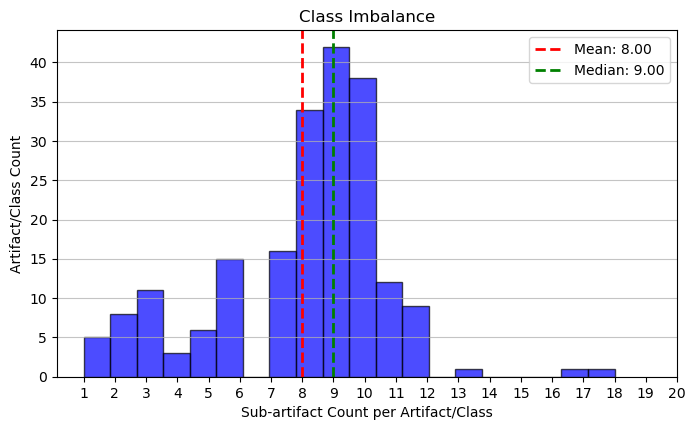

In [8]:
# Group by 'Artifact #' and compute the size of each group
group_sizes = tmf_sub_artifacts.groupby('Artifact #').size()

# Plot the histogram
plt.figure(figsize=(8, 4.5))
plt.hist(group_sizes, bins=20, alpha=0.7, color='blue', edgecolor='black')

# Plot the mean and median
mean_size = group_sizes.mean()
median_size = group_sizes.median()
plt.axvline(mean_size, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_size:.2f}')
plt.axvline(median_size, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_size:.2f}')

plt.legend()
plt.title('Class Imbalance')
plt.xlabel('Sub-artifact Count per Artifact/Class')
plt.ylabel('Artifact/Class Count')
plt.grid(axis='y', alpha=0.75)
plt.xticks(range(1, 21))
plt.savefig("images/class_imbalance.png", bbox_inches='tight')
plt.show()


In [9]:
# Statistics of sub-artifact counts
tmf_sub_artifacts.groupby(['Artifact #']).size().describe().T

count    202.00000
mean       8.00000
std        2.85469
min        1.00000
25%        7.00000
50%        9.00000
75%       10.00000
max       18.00000
dtype: float64

In [10]:
def oversampling(df, class_label, max_size=15):
    '''Over sample minority classes. If the max_size is not given, classes
    will be oversampled to match the majority class'''
    if not max_size:
        max_size = df[class_label].value_counts().max()

    # Create a new DataFrame to hold the oversampled data
    lst = [df]
    for class_index, group in df.groupby(class_label):
        if (max_size - len(group) > 0):
            lst.append(group.sample(max_size-len(group), replace=True))

    df_oversampled = pd.concat(lst)
    # Shuffle the DataFrame because all samples of the same class are grouped together
    df_oversampled = df_oversampled.sample(frac=1).reset_index(drop=True)
    return df_oversampled


#### Balance the Classesd by Oversampling

In [11]:
corpus = tmf.copy()
text_var  = 'Subartifact Title'
target = 'Artifact #'
tokenized_input_col = 'tokens'

tmf_tokenizer = LemmatizingStemmingTransformer(stop_words=True)
corpus[tokenized_input_col] = tmf_tokenizer.transform(corpus[text_var])
print(f'Time lapsed: {tmf_tokenizer.transform_time}')

print(f"Origional Shape: {corpus.shape}")
balanced_corpus = oversampling(corpus, target)
print(f"After oversampling: {balanced_corpus.shape}")

X, y = balanced_corpus[[tokenized_input_col]], balanced_corpus[target]
balanced_corpus[[text_var, tokenized_input_col, target]]

Time lapsed: 1.6000843048095703
Origional Shape: (1616, 7)
After oversampling: (3035, 7)


,Subartifact Title,tokens,Artifact #
0,regulatori applic product import,regulatori applic product import,03.02.01
1,special event interest,special event interest,07.02.04
2,staff affili form,staff affili form,05.02.06
3,clinic trial progress submiss irb/iec,clinic trial progress submiss irb/iec,04.03.02
4,site qualif clinic studi,site qualif clinic studi,05.01.03
...,...,...,...
3030,irt train attend log,irt train attend log,05.03.03
3031,crf field variabl link guid,crf field variabl link guid,10.02.02
3032,regulatori author safeti report,regulatori author safeti report,07.02.01
3033,document iec member experi,document iec member experi,04.01.03


### Feature Engineering
- Use TD-IDF vectorizer for uni-grams and bi-grams

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import iqr

In [13]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                             stop_words=stopwords.words('english'),
                             lowercase=True)
X_vect = vectorizer.fit_transform(X['tokens'])
print(X_vect.shape)

(3035, 3555)


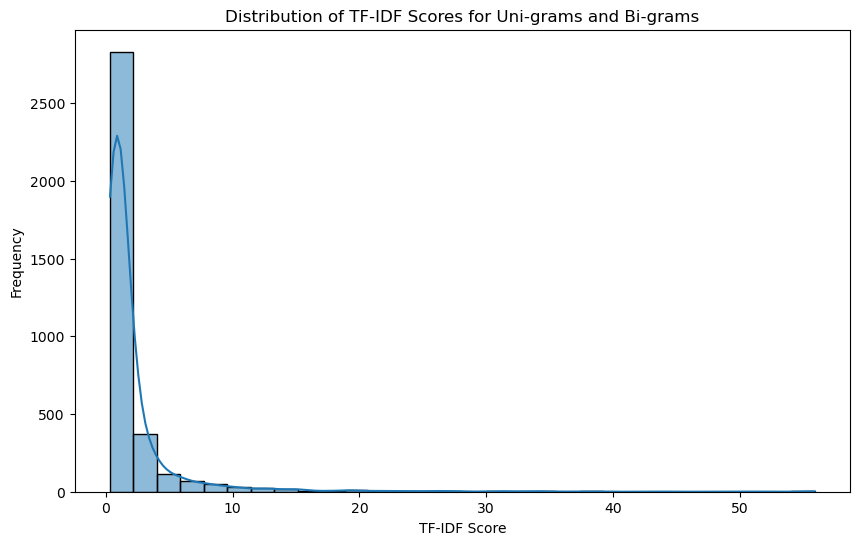

In [14]:
# Convert the sparse TF-IDF matrix to a dense array
dense_X_vect = X_vect.todense()

# Sum up the TF-IDF scores for each feature across all documents
feature_sums = np.array(dense_X_vect.sum(axis=0)).flatten()

# Plot the distribution of TF-IDF scores
plt.figure(figsize=(10, 6))
sns.histplot(feature_sums, bins=30, kde=True)
plt.title('Distribution of TF-IDF Scores for Uni-grams and Bi-grams')
plt.xlabel('TF-IDF Score')
plt.ylabel('Frequency')
plt.show()

#### Visualize the top most distinctive features (n-grams)

In [15]:
# Get feature names
feature_names = np.array(vectorizer.get_feature_names_out())

# Compute the maximum TF-IDF score for each feature across all documents
max_tfidf_scores = X_vect.max(axis=0).toarray().flatten()
# Get the indices of the top 100 features
top_100_indices = max_tfidf_scores.argsort()[-100:][::-1]

# Get the names and scores of the top 100 features
top_100_features = feature_names[top_100_indices]
top_100_scores = max_tfidf_scores[top_100_indices]

# Plot the top 100 features
# plt.figure(figsize=(10, 15))
# plt.barh(range(100), top_100_scores[::-1], align='center')
# plt.yticks(range(100), top_100_features[::-1])
# plt.xlabel('Maximum TF-IDF Score')
# plt.title('Top 100 Most Distinctive Features')
# plt.gca().invert_yaxis()  # Invert the y-axis to have the highest score on top
# plt.show()

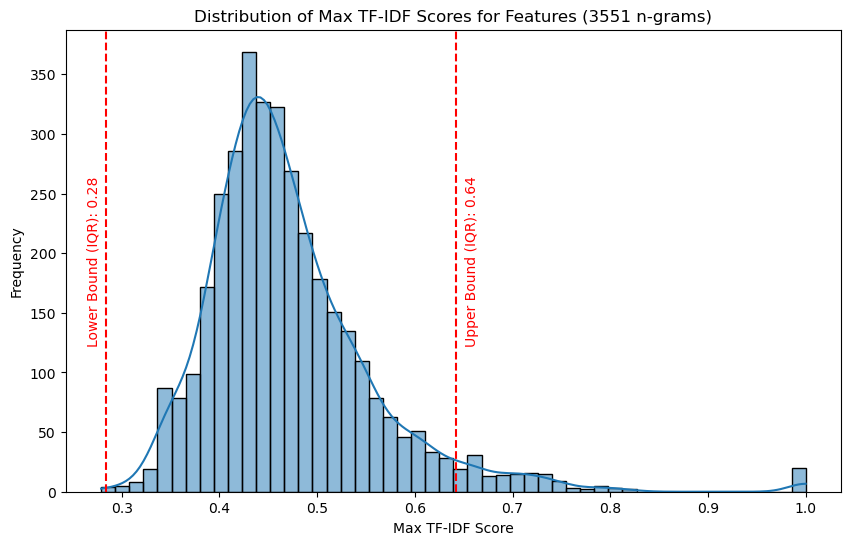

Number of distinct uni-grams and bi-grams: 3551


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import iqr

# Convert to a dense array
dense_X_vect = X_vect.todense()

# Find the maximum TF-IDF score for each feature across all documents
max_tfidf_scores = np.max(dense_X_vect, axis=0)

# Flatten the array to make it one-dimensional
max_tfidf_scores = np.array(max_tfidf_scores).flatten()

# Calculate the IQR
iqr_value = iqr(max_tfidf_scores)
# Determine the lower and upper bounds to identify outliers
Q1 = np.percentile(max_tfidf_scores, 25)
Q3 = np.percentile(max_tfidf_scores, 75)
lower_bound = Q1 - 1.5 * iqr_value
upper_bound = Q3 + 1.5 * iqr_value
distinctive_features_count = np.sum(max_tfidf_scores > lower_bound)

plt.figure(figsize=(10, 6))
sns.histplot(max_tfidf_scores, bins=50, kde=True)
distinctive_features_count = np.sum(max_tfidf_scores > lower_bound)
plt.title(f'Distribution of Max TF-IDF Scores for Features ({distinctive_features_count} n-grams)')
plt.xlabel('Max TF-IDF Score')
plt.ylabel('Frequency')

# Adding a vertical lines for the lower bound and upper bound
plt.axvline(x=lower_bound, color='r', linestyle='--')
plt.text(lower_bound - 0.02, plt.ylim()[1]*0.5, f'Lower Bound (IQR): {lower_bound:.2f}',
         rotation=90, verticalalignment='center', color='red', fontsize=10)
plt.axvline(x=upper_bound, color='r', linestyle='--')
plt.text(upper_bound + 0.01, plt.ylim()[1]*0.5, f'Upper Bound (IQR): {upper_bound:.2f}',
         rotation=90, verticalalignment='center', color='red', fontsize=10)

plt.savefig("images/TF-IDF_distribution.png", bbox_inches='tight')
plt.show()

print(f"Number of distinct uni-grams and bi-grams: {distinctive_features_count}")

### Load Unseen Test Data

In [17]:
# Read selected columns from the TMF Reference Model's speccifications
job = db.load_data("WO42", columns="AH, AJ")
job.rename(columns={"API Extracted Title": "Title"}, inplace=True)
job.dropna(inplace=True)
job

,Artifact #,Title
0,02.01.04,"Salix Pharmaceuticals, Inc. Phase II Study: Me..."
1,02.01.02,ADVANCING TREATMENT: Phase II Study on Mesalam...
2,02.01.04,Protocol MGIB2051 Amendment 01 - Mesalamine St...
3,02.01.04,MGIB2051 Protocol Amendment 02 Proposal Decisi...
4,02.01.04,"Salix Pharmaceuticals, Inc. Study MGIB2051 Ame..."
...,...,...
752,10.04.03,InForm 4.6 System Release Confirmation 14 Octo...
753,10.04.03,Production Systems Hardware & Software Install...
754,10.04.03,Operational Qualification for Production I46SH...
764,10.03.09,11-09-2010: Salix Pharmaceuticals Clinical Stu...


#### Preprocess the Test Data

In [18]:
input_var  = 'Title'
target = 'Artifact #'
tokenized_input_col = 'tokens'

tmf_tokenizer = LemmatizingStemmingTransformer()
job[tokenized_input_col] = tmf_tokenizer.transform(job[input_var])
X_job, y_job = job[tokenized_input_col], job[target]

tmf_tokenizer = LemmatizingStemmingTransformer()

# Ensure the input column exists
assert input_var in job.columns, f"{input_var} column not found in 'job' DataFrame."

# Transform and assign the data
job[tokenized_input_col] = tmf_tokenizer.transform(job[input_var])

# Print transformation time
print(f'Time lapsed: {tmf_tokenizer.transform_time:.4f}')

# Ensure the transformed input and target columns exist
assert tokenized_input_col in job.columns, f"{transformed_input} column not found in 'job' DataFrame."
assert target in job.columns, f"{target} column not found in 'job' DataFrame."

# Assign features and target
X_job, y_job = job[[tokenized_input_col]], job[target]

# Output the number of rows processed
print(f'{job.shape[0]} rows of unseen data')


Time lapsed: 2.6702
439 rows of unseen data


### Model Selection and GridSearchCV Configuration

In [19]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import gc

# Initialize models to be evaluated
models = {
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(multi_class='multinomial', 
                                              class_weight='balanced',
                                              penalty='l2',
                                              max_iter=10000),
    'SVM': SVC(coef0=1, probability=True,
               decision_function_shape = 'ovo',
               class_weight='balanced'),
    'Random Forest': RandomForestClassifier(),
#     'Naive Bayes': MultinomialNB(fit_prior=True),
#     'Gradient Boosting': LGBMClassifier(objective='multiclass', min_split_gain=0.01),
}

# Define hyperparameters for each grid search. 
# The named step for the classifer in the pipleline is assumed to be 'clf'
param_grids = {
    'KNN': {'clf__n_neighbors': [2, 3, 5], 
            'clf__weights': ['distance', 'uniform']
           },
    'Logistic Regression': {'clf__C': [10_000, 10e5],
                           },
    'Naive Bayes': {'clf__alpha': [0.01, 0.05],
                   },
    'SVM': {'clf__C': [50, 100, 1000],
            'clf__max_iter': [10000, -1],
            'clf__kernel': ['poly', 'rbf', 'sigmoid'],
            'clf__degree': [2, 3],
           },
    'Random Forest': {'clf__n_estimators': [250, 500, 750],
                      'clf__criterion': ['entropy', 'gini'],
                     },
    }

In [20]:
# Initialize result dictionary
res_dict = {'Classifier': [],
            'Train score': [], 
            'Test score': [], 
            'Avg. model eval time': [],
           }
best_models = []

preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(use_idf=True, ngram_range=(1, 2), 
                                  stop_words=stopwords.words('english'),
                                  lowercase=True), tokenized_input_col)
    ],
    remainder='passthrough')

# Run Grid Search on each model
for name, model in models.items():
    pipeline = Pipeline([
    ('correspondence_transformer', CorrespondenceTransformer()),
    ('preprocessor', preprocessor),
    ('clf', model)
     ])

    grid_search = GridSearchCV(pipeline, param_grids[name], 
                               scoring = 'accuracy',
                               refit=True, cv=4, n_jobs=6)
    # Force a garbage collection for eval time comparison
    gc.collect()    

    start_time = time.time()
    grid_search.fit(X, y)
    grid_search_time = time.time() - start_time
    
    # Fit the best model
    model = grid_search.best_estimator_
    start_time = time.time()
    model.fit(X, y)
    best_models.append((name, model))
#     fit_time = time.time() - start_time
    train_score = model.score(X, y)
    test_score = model.score(X_job, y_job)
    
    res_dict['Classifier'].append(name)
    res_dict['Train score'].append(train_score)
    res_dict['Test score'].append(test_score)
    res_dict['Avg. model eval time'].append(grid_search_time/len(grid_search.cv_results_['params']))
    print(grid_search.best_estimator_.named_steps['clf'])
    print(f"Accuracy: {test_score:.4f}\n-")

metrics_df = pd.DataFrame(res_dict).set_index('Classifier')
metrics_df

KNeighborsClassifier(weights='distance')
Accuracy: 0.3804
-
LogisticRegression(C=10000, class_weight='balanced', max_iter=10000,
                   multi_class='multinomial')
Accuracy: 0.5034
-
SVC(C=100, class_weight='balanced', coef0=1, decision_function_shape='ovo',
    degree=2, kernel='sigmoid', max_iter=10000, probability=True)
Accuracy: 0.4442
-
RandomForestClassifier(n_estimators=750)
Accuracy: 0.3303
-


,Train score,Test score,Avg. model eval time
Classifier,,,
KNN,0.995387,0.380410,0.357164
Logistic Regression,0.995387,0.503417,190.558583
SVM,0.993410,0.444191,2.403246
Random Forest,0.995387,0.330296,26.867414


### Construct a VotingClassifier Ensemble

In [21]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

# Instantiate the VotingClassifier with soft voting
voting_ensemble = VotingClassifier(estimators=best_models, voting='soft')

start_fit_time = time.time()
voting_ensemble.fit(X, y)
ensemble_score = voting_ensemble.score(X_job, y_job)
fit_time = time.time() - start_fit_time
print(f"Voting Classifier score: {ensemble_score}")
# Compute the train score
ensemble_train_score = voting_ensemble.score(X, y)
avg_model_eval_time = fit_time / len(best_models)
# Add the ensemble classifier's metrics to the DataFrame
metrics_df.loc['Voting Classifier'] = [ensemble_train_score, ensemble_score, avg_model_eval_time]

metrics_df

Voting Classifier score: 0.5216400911161732


,Train score,Test score,Avg. model eval time
Classifier,,,
KNN,0.995387,0.380410,0.357164
Logistic Regression,0.995387,0.503417,190.558583
SVM,0.993410,0.444191,2.403246
Random Forest,0.995387,0.330296,26.867414
Voting Classifier,0.995387,0.521640,23.742470


### Top-n Accuracy Evaluation
Many of the document types defined in the Reference Model are entity specific. For example, to show a person is qualified to perform a clinical trial related task, the documentation showing the qualification of the person, such as a medical license or Curriculum Vitae is collected and becomes a part of the TMFs. The Reference Model defines 'Principal Investigator's Curriculum Vitae (CV)', 'Sub-investigator’s CV', 'Coordinating investigator's CV', 'Laboratory Staff's CV' and 'Committee Member's CV' as different document types. However, in practice, the position of the qualified person rarely shows up on a CV. **Simply put, the title of a document alone does not always be able to distinguish these entity-specific document types**.

Therefore, I adopt a "Top-n Accuracy" scoring scheme to better assess the performance of the model under these circumstances. Instead of using the single outcome prediction, I consider the top 3 or top 5 probabilities produced by a model as the prediction of the model. Specifically, if one of the top-3 or top-5 prediction candidates matches the correct classification, it is considered a correct classification by the model.

In [22]:
# Custom top-n accuracy evaluation function
def top_n_accuracy(y, n, predicted_probabilities, class_labels):
    '''
    Modified top_n_accuracy function to handle cases where class_labels may not include
    the full list of class labels present in y. Unseen labels are treated as incorrect predictions.
    '''
    # Ensure y is a numpy array for consistent indexing
    y = np.array(y)

    # Determine the top n predicted class indices for each sample
    top_n_pred_indices = np.argsort(predicted_probabilities, axis=1)[:, -n:]

    # Initialize a list to store whether each prediction is correct
    correct_predictions = []

    for i, true_label in enumerate(y):
        # Check if the true label is in class_labels; if not, the prediction is automatically incorrect
        if true_label in class_labels:
            # Find the index of the true label in class_labels
            true_label_index = np.where(class_labels == true_label)[0][0]
            # Check if this index is in the top n predictions for the current sample
            correct_predictions.append(true_label_index in top_n_pred_indices[i])
        else:
            # If the true label is not in class_labels, it's an incorrect prediction
            print(f"Unseen class label: {true_label}")
            correct_predictions.append(False)

    # Calculate the top n accuracy
    top_n_accuracy = np.mean(correct_predictions)
    
    return top_n_accuracy

# Ensure the metrics_df has columns for top-3 and top-5 accuracies
if 'Top-3 Accuracy' not in metrics_df.columns:
    metrics_df['Top-3 Accuracy'] = 0.0
if 'Top-5 Accuracy' not in metrics_df.columns:
    metrics_df['Top-5 Accuracy'] = 0.0

# Function to compute top-n accuracy for a given model
def compute_top_n_accuracies(model, X, y, class_labels, n_values=[3, 5]):
    predicted_probabilities = model.predict_proba(X)
    accuracies = {}
    for n in n_values:
        acc = top_n_accuracy(y, n, predicted_probabilities, class_labels)
        accuracies[f'Top-{n} Accuracy'] = acc
    return accuracies

In [23]:
class_labels = voting_ensemble.classes_
# Compute top-n accuracies for models in best_models
for name, model in best_models:
    accuracies = compute_top_n_accuracies(model, X_job, y_job, class_labels)
    metrics_df.loc[name, 'Top-3 Accuracy'] = accuracies['Top-3 Accuracy']
    metrics_df.loc[name, 'Top-5 Accuracy'] = accuracies['Top-5 Accuracy']

# Compute top-n accuracies for the voting classifier
voting_accuracies = compute_top_n_accuracies(voting_ensemble, X_job, y_job, class_labels)
metrics_df.loc['Voting Classifier', 'Top-3 Accuracy'] = voting_accuracies['Top-3 Accuracy']
metrics_df.loc['Voting Classifier', 'Top-5 Accuracy'] = voting_accuracies['Top-5 Accuracy']

metrics_df


,Train score,Test score,Avg. model eval time,Top-3 Accuracy,Top-5 Accuracy
Classifier,,,,,
KNN,0.995387,0.380410,0.357164,0.792711,0.799544
Logistic Regression,0.995387,0.503417,190.558583,0.687927,0.726651
SVM,0.993410,0.444191,2.403246,0.694761,0.785877
Random Forest,0.995387,0.330296,26.867414,0.587699,0.674260
Voting Classifier,0.995387,0.521640,23.742470,0.772210,0.876993


### Calculate the Top-n Accuracy Baselines

In [24]:
unseen_data_distribution = y_job.value_counts(normalize=True).sort_values(ascending=False)
accumulated_percentage_counts = unseen_data_distribution.cumsum()
top1_baseline = accumulated_percentage_counts[0]
top3_baseline = accumulated_percentage_counts[2]
top5_baseline = accumulated_percentage_counts[4]
print(accumulated_percentage_counts)
print(len(y_job))

Artifact #
99.99.98    0.261959
99.99.97    0.473804
99.98.99    0.519362
10.02.05    0.560364
04.01.02    0.599089
              ...   
09.02.01    0.990888
10.03.03    0.993166
04.03.03    0.995444
05.03.01    0.997722
99.99.96    1.000000
Name: proportion, Length: 68, dtype: float64
439


### Visualize Models' Top-n Accuracy Performance

C:\Users\Jimmy\AppData\Local\Temp\ipykernel_3392\2091128296.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data.rename(columns={'index': 'Classifier'}, inplace=True)


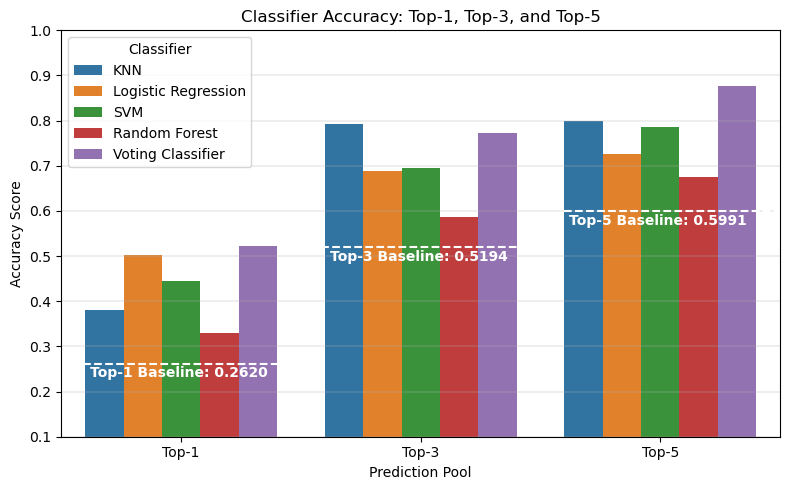

In [25]:
plot_data = metrics_df[['Test score', 'Top-3 Accuracy', 'Top-5 Accuracy']]

# Reset index to include Classifier names as a column
plot_data.reset_index(inplace=True)
plot_data.rename(columns={'index': 'Classifier'}, inplace=True)

# Melt the DataFrame to long format
metrics_long = pd.melt(plot_data, id_vars='Classifier', var_name='Metric', value_name='Accuracy')

# Map metric names to 'Top-1', 'Top-3', and 'Top-5'
metric_mapping = {'Test score': 'Top-1', 'Top-3 Accuracy': 'Top-3', 'Top-5 Accuracy': 'Top-5'}
metrics_long['Metric'] = metrics_long['Metric'].map(metric_mapping)

# Plot using seaborn
plt.figure(figsize=(8, 5))
sns.barplot(data=metrics_long, x='Metric', y='Accuracy', hue='Classifier', width=0.8)

# Drawing horizontal lines for baselines
plt.axhline(xmax=0.3, y=top1_baseline, color='white', linestyle='--')
plt.axhline(xmin=0.3 ,xmax=0.65, y=top3_baseline, color='white', linestyle='--')
plt.axhline(xmin=0.7, y=top5_baseline, color='white', linestyle='--')

# Adding annotations
plt.text(x=-0.38, y=top1_baseline - 0.03, s=f'Top-1 Baseline: {top1_baseline:.4f}', color='white', fontweight='bold')
plt.text(x=0.62, y=top3_baseline - 0.03, s=f'Top-3 Baseline: {top3_baseline:.4f}', color='white', fontweight='bold')
plt.text(x=1.62, y=top5_baseline - 0.03, s=f'Top-5 Baseline: {top5_baseline:.4f}', color='white', fontweight='bold')

plt.title('Classifier Accuracy: Top-1, Top-3, and Top-5')
plt.xlabel('Prediction Pool')
plt.ylabel('Accuracy Score')
plt.ylim((0.1, 1))
# plt.legend(title='Classifier', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linewidth=0.3)
plt.savefig("images/top-n-accuracy.png", bbox_inches='tight')
plt.show()


### Accuracy vs. Speed

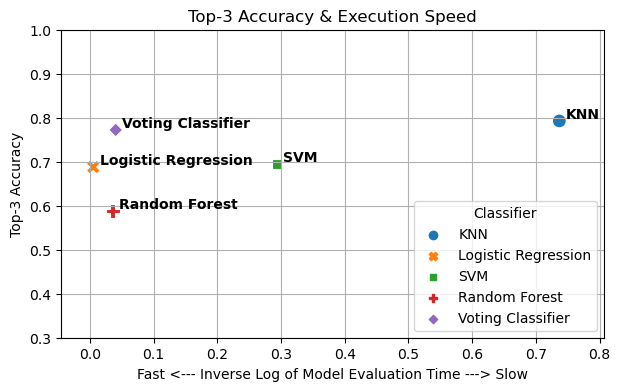

In [26]:
plot_data = metrics_df.reset_index()
plot_data['Inv Log Avg. Eval Time'] = np.exp(-np.log(plot_data['Avg. model eval time'] + 1))  # Adding 1 to avoid log(0)

plt.figure(figsize=(7, 4))
scatter = sns.scatterplot(data=plot_data, y='Top-3 Accuracy', x='Inv Log Avg. Eval Time', hue='Classifier', style='Classifier', s=100)

# Adding annotations
for line in range(0, plot_data.shape[0]):
     scatter.text(plot_data['Inv Log Avg. Eval Time'].iloc[line]+0.01, plot_data['Top-3 Accuracy'].iloc[line], 
                  plot_data['Classifier'].iloc[line], verticalalignment='bottom', 
                  size='medium', color='black', weight='semibold')

plt.title('Top-3 Accuracy & Execution Speed')
plt.ylabel('Top-3 Accuracy')
plt.ylim(0.3, 1)
plt.xlabel('Fast <--- Inverse Log of Model Evaluation Time ---> Slow')
plt.grid(True)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust x-axis to better visualize the transformed scale
plt.xlim(left=np.min(plot_data['Inv Log Avg. Eval Time']) - 0.05, right=np.max(plot_data['Inv Log Avg. Eval Time']) + 0.07)
plt.savefig("images/accuracy_vs_time.png", bbox_inches='tight')
plt.show()

### Build a Recurrent Neural Network Model with a LSTM Layer

In [28]:
import gensim
from gensim.models import KeyedVectors

# https://github.com/ncbi-nlp/BioSentVec
# Embeddings using PubMed and the clinical notes from MIMIC-III Clinical Database

# bioword2vec = gensim.models.KeyedVectors.load_word2vec_format(
#      'BioWordVec_PubMed_MIMICIII_d200.vec.bin',
#       binary=True,
#       # limit=None, # this fuckin thing has 4 billion tokens (4E9)
#       limit=int(4E7) # faster load if you limit to most frequent terms
# )
# print(bioword2vec)
# print('Using %s word vectors.' % len(word2vec.wv.vocab))

In [30]:
import joblib
# Uncomment if load the word2vec for the first time
# import gensim.downloader as api
# word2vec_path = api.load("word2vec-google-news-300", return_path=True)
# print(word2vec_path)

# word2vec_path = 'data\gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz'
# word2vec_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# Save the model
# joblib.dump(word2vec_model, "word2vec_pretained_model.joblib")
word2vec_model = joblib.load("word2vec_pretained_model.joblib")

### Incoorperate pre-trained Word2Vec Model

In [31]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

tokenized_input_col = 'tokens'

X_input = X[tokenized_input_col]

embedding_dim = 300  # Size of the Word2Vec word vectors
max_length = 32  # Max length of a sequence
oov_tok = "<OOV>"  # Token for out of vocabulary words
# Tokenize
tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(X_input)
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1  # Assuming 'tokenizer' is your Keras Tokenizer instance

# Initialize the matrix with zeros
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Fill the embedding matrix with Word2Vec vectors
for word, i in tokenizer.word_index.items():
    if word in word2vec_model:
        embedding_vector = word2vec_model[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
sequences = tokenizer.texts_to_sequences(X_input)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

In [34]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, 
                                                    stratify=y, random_state=42)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
print(X_train.shape, X_train.dtype)
print(y_train_encoded.shape, y_train_encoded.dtype)

# Compute class weights to address class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weight_dict = dict(enumerate(class_weights))
print(f"Vocabruary Size: {vocab_size}")
# print(word_index)

(2428, 32) int32
(2428,) int32
Vocabruary Size: 755


### Configure the Model

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras import backend as K

# @tf.keras.utils.register_keras_serializable()
# def focal_loss(y_true, y_pred, gamma=2., alpha=.25):
#     pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
#     pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
#     return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.sum((1-alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

# Register the loss function with Keras so that the fitted model can be saved correctly
@tf.keras.utils.register_keras_serializable()
def focal_loss(gamma=2.0, alpha=0.25):
    ''' A better loss function for imbalanced class distribution'''
    @tf.keras.utils.register_keras_serializable()
    def focal_loss_fixed(y_true, y_pred):
        # One-hot encode y_true to match the shape of y_pred
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        
        # Clip y_pred to prevent log(0) error
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        
        # Calculate Focal Loss
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=1)
    return focal_loss_fixed

nn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_shape=(max_length,), 
              trainable=False),
    Bidirectional(LSTM(128)),
    Dense(len(np.unique(y)), activation='softmax')  # Adjust according to your number of classes
])
# passing the embedding_matrix in model definition would cause an error
nn_model.layers[0].set_weights([embedding_matrix])

# focal loss can better address class imbalance but require tuning
# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
nn_model.compile(optimizer='adam', loss=focal_loss(gamma=2.0, alpha=0.25), metrics=['accuracy'])


C:\Users\Jimmy\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [36]:
from tensorflow.keras.callbacks import EarlyStopping

# tf.random.set_seed(42)
num_epochs = 100  # Number of epochs
early_stopping = EarlyStopping(monitor='val_accuracy', 
                               min_delta=0.00005, mode='max', patience=10, 
                               restore_best_weights=True,
                               verbose=1)
# Train the model
history = nn_model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded),
                    class_weight=class_weight_dict,
                    epochs=num_epochs, 
                    callbacks=[early_stopping],
                    verbose=1)

# Determine the best validation accuracy, considering early stopping possibility
best_val_accuracy = max(history.history['val_accuracy'])
print(f"\nBest validation accuracy: {best_val_accuracy:.4f}")

nn_model.summary()

Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.0713 - loss: 1.3001 - val_accuracy: 0.2998 - val_loss: 1.1621
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3178 - loss: 0.9945 - val_accuracy: 0.5470 - val_loss: 0.6187
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6876 - loss: 0.4201 - val_accuracy: 0.7232 - val_loss: 0.3407
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8558 - loss: 0.1856 - val_accuracy: 0.7825 - val_loss: 0.2359
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9261 - loss: 0.0905 - val_accuracy: 0.8237 - val_loss: 0.1841
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9595 - loss: 0.0480 - val_accuracy: 0.8254 - val_loss: 0.1620
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9754 - loss: 0.0307 - val_accuracy: 0.8353 - val_loss: 0.1467
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9824 - loss: 0.0201 - val_accuracy: 0.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 32, 300)             │         226,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 256)                 │         439,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 202)                 │          51,914 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,153,132 (8.21 MB)

 Trainable params: 717,710 (2.74 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,435,422 (5.48 MB)

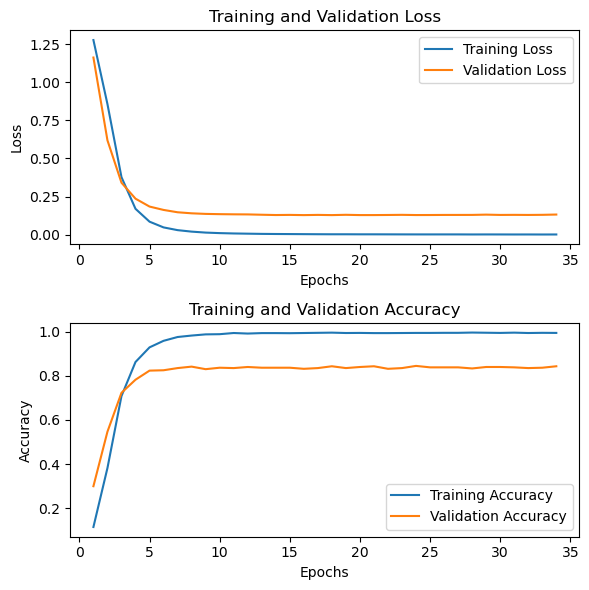

In [39]:
# Extracting the history data
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

actual_epochs = len(training_loss)
epochs_range = range(1, actual_epochs + 1)

# Finding the lowest validation loss and its epoch
min_val_loss = min(validation_loss)
min_val_loss_epoch = validation_loss.index(min_val_loss) + 1  # Adding 1 since epochs start from 1

# Plotting Training and Validation Loss
plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

# Adding annotation for the lowest validation loss
# plt.annotate(f'Lowest Validation Loss: {min_val_loss:.4f}\nat Epoch {min_val_loss_epoch}',
#              xy=(min_val_loss_epoch, min_val_loss + 0.15),
#              xytext=(min_val_loss_epoch, min_val_loss + 0.05),
#              arrowprops=dict(facecolor='black', shrink=0.05),
#              horizontalalignment='left', verticalalignment='bottom')

plt.legend()

# Plotting Training and Validation Accuracy
plt.subplot(2, 1, 2)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('images/lstm.png', bbox_inches='tight')
plt.show()


In [38]:
test_loss, test_acc = nn_model.evaluate(X_test, y_test_encoded)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# Generate predictions
predictions = nn_model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Identify missed predictions
missed_indices = np.where(predicted_classes != y_test_encoded)[0]
missed_titles = [X['tokens'].iloc[idx] for idx in missed_indices]  # Assuming 'X' is not shuffled
missed_actual = y_test_encoded[missed_indices]
missed_predicted = predicted_classes[missed_indices]

nn_missed_df = pd.DataFrame({'Title': missed_titles, 'Actual': missed_actual, 'Predicted': missed_predicted})
print(nn_missed_df)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8617 - loss: 0.1119
Test Loss: 0.12843120098114014
Test Accuracy: 0.8451400399208069
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
                                      Title  Actual  Predicted
0               sampl preserv condit record     158         36
1                        investig agreement      27        200
2   third-parti qualiti questionnair result     186        200
3                           verif statement      69         91
4                        committ correspond     166        145
..                                      ...     ...        ...
89        irt user accept test ( uat ) sign     193        189
90             interim statist analysi plan      45          5
91                      devic calibr certif      95        104
92                  investig report irb/iec      94         53
93                 epro data compil subject      54         64

[94 rows x 3 columns]
